In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.3 MB/s eta 0:00:00


In [ ]:
!pip install zemberek-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141210 sha256=cfb9e1255af1e85b6b8ebb39dec612a43839ec6f1ba51f2bf10055466a9fbc53
  Stored in directory: /root/.cache/pip/wheels/a7/20/bd/e1477d664f22d99989fd28ee1a43d6633dddb5cb9e801350d5
Successfully built antlr4-python3-runtime


# 1.Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import string
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# 2.Loading Turkish Tweets Dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving TurkishTweets.xlsx to TurkishTweets.xlsx


In [ ]:
dataset_tweets = pd.read_excel('TurkishTweets.xlsx')

In [ ]:
dataset_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   3999 non-null   object
 1   Etiket  4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


In [ ]:
dataset_tweets.Etiket.value_counts()

kızgın     800
korku      800
mutlu      800
surpriz    800
üzgün      800
Name: Etiket, dtype: int64

In [ ]:
dataset_tweets.rename(columns = {'Etiket':'Label'}, inplace=True)
dataset_tweets['Label'] = np.where(dataset_tweets['Label'] == 'kızgın', 0,
                                   np.where(dataset_tweets['Label'] == 'korku', 1,
                                            np.where(dataset_tweets['Label'] == 'mutlu', 2,
                                                     np.where(dataset_tweets['Label'] == 'surpriz', 3, 4))))

In [ ]:
dataset_tweets.head()

,Tweet,Label
0,Allah'ım çıldıracağım. Yemin ederim çıldıracağ...,0
1,site ne zaman çalıştıda ürün stokları bitti di...,0
2,Sebebi neydi ki diye bağıracağım şimdi az kaldı,0
3,Black friday ne amk bu yıl çıkardınız bu bokud...,0
4,kısa kısa cevaplar vericeksen niye yazıyorsun ...,0


In [ ]:
dataset_tweets[dataset_tweets.Tweet.isna()]

,Tweet,Label
3430,NaN,4


In [ ]:
dataset_tweets.dropna(inplace=True)
dataset_tweets.reset_index(drop=True, inplace=True)

In [ ]:
# Get the lists of tweetz and their labels.
tweets = dataset_tweets.Tweet.values
labels = dataset_tweets.Label.values

In [ ]:
tweets

array(["Allah'ım çıldıracağım. Yemin ederim çıldıracağım sinirimden. Bir yerden de çıkaramıyorum cam çerçeve indireceğim şimdi ne varsa.",
       'site ne zaman çalıştıda ürün stokları bitti diyor mal mısınız oğlum kimi kandırıyorsunuz!',
       'Sebebi neydi ki diye bağıracağım şimdi az kaldı', ...,
       'Çok şey istiyorum ama sonu hep fiyasko MUTSUZUM',
       'Garip bir şekilde canım çok yanıyor moralim bozuk',
       'Üzgünüm birazdan takipten çıkarıp hesabımı gizliye alıcağım daha fazla acı çekmeye gerek yok'],
      dtype=object)

## Unigram and Bigrams for each class

In [ ]:
def process_text(dataframe, label=0, gram='uni'):

  stop_words=stopwords.words("turkish")
  exclude = set(string.punctuation)

  #sentiments based on given label
  df_pos=dataframe[dataframe["Label"]==label]

  token_list=[]

  for i,r in df_pos.iterrows():
      text=''.join(ch for ch in df_pos["Tweet"][i] if ch not in exclude and ch != "’") #remove punctuations from the text in order not to distort frequencies
      tokens=word_tokenize(text)
      tokens=[tok.lower() for tok in tokens if tok not in stop_words] #remove stopwords from the text in order not to distort frequencies
      token_list.extend(tokens)

  if gram == 'uni':
    frequencies=Counter(token_list)
  else:
    bigrams=list(ngrams(token_list,2))
    frequencies=Counter(bigrams)

  frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
  top_15=dict(frequencies_sorted[0:15])

  return top_15

In [ ]:
def plot_grams(top_15, sentiment='positive'):
  plt.rcdefaults()
  fig, ax = plt.subplots()

  # Example data
  ngram = top_15.keys()
  y_pos = np.arange(len(ngram))
  performance = top_15.values()


  ax.barh(y_pos, performance, align='center')
  ax.set_yticks(y_pos)
  ax.set_yticklabels(ngram)
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel('Counts')
  first_name = "John"
  sent = sentiment
  ax.set_title("Top-15 Most Common Bigrams in {} Comments".format(sent))

  plt.show()

### Unigram & Bigram - for different classes

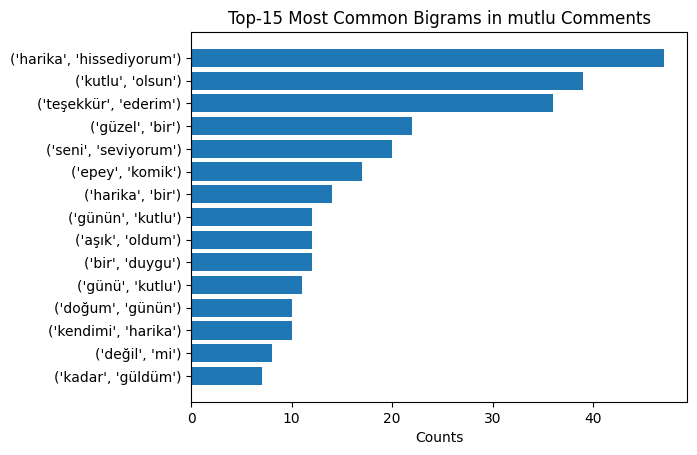

In [ ]:
sentiment_dict = {"kızgın":0,
                  "korku":1,
                  "mutlu":2,
                  "surpriz":3,
                  "üzgün":4}
plot_grams(process_text(dataset_tweets, label=2, gram='bi'), sentiment='mutlu')

# 3.Tokenization & Input Formatting

In [ ]:
from transformers import AutoModel, AutoTokenizer

# Load pretrained model/tokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Tweets");
    return

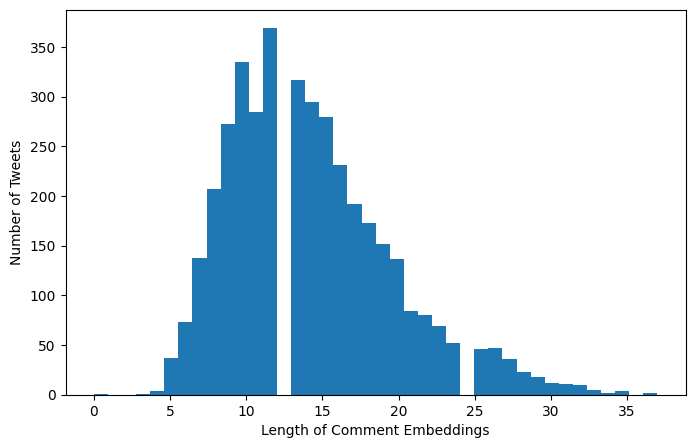

In [ ]:
plot_sentence_embeddings_length(tweets, tokenizer)

In [ ]:
for i in range(5):

  # Print the original sentence.
  print(' Original: ', tweets[i])

  # Print the sentence split into tokens.
  print('Tokenized: ', tokenizer.tokenize(tweets[i]))

  # Print the sentence mapped to token ids.
  print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[i])))
  print("\n")

 Original:  Allah'ım çıldıracağım. Yemin ederim çıldıracağım sinirimden. Bir yerden de çıkaramıyorum cam çerçeve indireceğim şimdi ne varsa.
Tokenized:  ['Allah', "'", 'ım', 'çıldır', '##acağım', '.', 'Yemin', 'ederim', 'çıldır', '##acağım', 'sinir', '##imden', '.', 'Bir', 'yerden', 'de', 'çıkara', '##mıyorum', 'cam', 'çerçeve', 'indir', '##eceğim', 'şimdi', 'ne', 'varsa', '.']
Token IDs:  [3199, 11, 26987, 24552, 6950, 18, 23533, 5002, 24552, 6950, 6689, 6063, 18, 2281, 7197, 2012, 14516, 7654, 4340, 17557, 3349, 4224, 3653, 2142, 4385, 18]


 Original:  site ne zaman çalıştıda ürün stokları bitti diyor mal mısınız oğlum kimi kandırıyorsunuz!
Tokenized:  ['site', 'ne', 'zaman', 'çalıştı', '##da', 'ürün', 'stok', '##ları', 'bitti', 'diyor', 'mal', 'mısınız', 'oğlum', 'kimi', 'kandır', '##ıyorsunuz', '!']
Token IDs:  [6521, 2142, 2248, 9879, 1986, 2782, 10992, 2037, 10638, 4022, 2810, 12760, 9747, 7470, 13413, 16566, 5]


 Original:  Sebebi neydi ki diye bağıracağım şimdi az kaldı
Token

In [ ]:
max_len = 0

# For every sentence...
for tweet in tweets:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  39


In [ ]:
indices=tokenizer.batch_encode_plus(list(tweets),
                                    max_length=64,
                                    add_special_tokens=True,
                                    return_attention_mask=True,
                                    pad_to_max_length=True,
                                    truncation=True)
input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]
print(input_ids[0])
print(tweets[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


[2, 3199, 11, 26987, 24552, 6950, 18, 23533, 5002, 24552, 6950, 6689, 6063, 18, 2281, 7197, 2012, 14516, 7654, 4340, 17557, 3349, 4224, 3653, 2142, 4385, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Allah'ım çıldıracağım. Yemin ederim çıldıracağım sinirimden. Bir yerden de çıkaramıyorum cam çerçeve indireceğim şimdi ne varsa.


In [ ]:
from sklearn.model_selection import train_test_split

# Use 99% for training and 1% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=42, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# 4.Train the Classification Model

In [ ]:
from transformers import AutoModelForSequenceClassification, AdamW, AutoConfig
config = AutoConfig.from_pretrained(
        "dbmdz/bert-base-turkish-cased",num_labels=5)
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = AutoModelForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-cased",config=config)

model.cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (32000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  betas=[0.9,0.999],
                  eps = 1e-6 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Training Loop

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 30 batches.
        if step % 30 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            )

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    30  of    100.    Elapsed: 0:00:12.
  Batch    60  of    100.    Elapsed: 0:00:22.
  Batch    90  of    100.    Elapsed: 0:00:31.

  Average training loss: 1.34
  Training epoch took: 0:00:35

Running Validation...
  Accuracy: 0.93
  Validation took: 0:00:03

======== Epoch 2 / 5 ========
Training...
  Batch    30  of    100.    Elapsed: 0:00:10.
  Batch    60  of    100.    Elapsed: 0:00:19.
  Batch    90  of    100.    Elapsed: 0:00:29.

  Average training loss: 0.17
  Training epoch took: 0:00:32

Running Validation...
  Accuracy: 0.99
  Validation took: 0:00:03

======== Epoch 3 / 5 ========
Training...
  Batch    30  of    100.    Elapsed: 0:00:09.
  Batch    60  of    100.    Elapsed: 0:00:19.
  Batch    90  of    100.    Elapsed: 0:00:28.

  Average training loss: 0.03
  Training epoch took: 0:00:32

Running Validation...
  Accuracy: 0.99
  Validation took: 0:00:03

======== Epoch 4 / 5 ========
Training...
  Batch    30  of 

# Inference to predict tweet samples

## Clean up the tweets

In [ ]:
import re
from zemberek import (TurkishMorphology,
                      TurkishSentenceNormalizer,
                      TurkishSpellChecker,
                      )
morphology = TurkishMorphology.create_with_defaults()
normalizer = TurkishSentenceNormalizer(morphology)

INFO:zemberek.morphology.turkish_morphology:TurkishMorphology instance initialized in 9.0670747756958


2023-06-14 22:32:43,196 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 9.0670747756958



In [ ]:
emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags = re.UNICODE)

def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    temp = re.sub("'", "", tweet) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9iığüşöç]+","", temp)
    temp = re.sub("#[A-Za-z0-9iığüşöç]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = emoji_pattern.sub(r'',temp)
#     temp = re.sub("[^a-z0-9İığüşöç]"," ", temp)
    temp = temp.split()
#     temp = [w for w in temp if not w in stopwords]
    temp = " ".join(word for word in temp)
    return temp

In [ ]:
raw_tweets = [
    'Özgür ve temiz bir turkiye icin 🇹🇷\n#SanaSoz \n#SanaSozBaharlarGelecek \n#cezevindenseskaydi \n#bizdendesanasoz \n#kilicdaroglu \n#GenelAf \n#infazduezenlemesi \n#ADALET \n#af \n#MilletTarihYazacak \n#Milletİttifakı https://t.co/9hhKFNftGs',
    'İşte bu! Türkiye’me yeni bir nefes #kılıçdaroğlu https://t.co/APxXlsvV4l',
    'MüslümanızElhamdürillah\nkalkıp da terörisİTlerin desteklediği yalamalara OY verirmiyiz\nkatiLLErin ittifakçılarına OY verirmiyiz\nİnsanız Biz,beynimiz var Allah akılfikir ihsan eylemiş\nanguSdeğilik\nKuranıkerim yakan bebek katillerine OY istiyor kasetci #Kılıçdaroğlu  ve adaylarda👇 https://t.co/n5hAsxKRqb',
    'Şimdi #HaberGlobal; İçişleri bakanı #Soylu, \n-#Demirtaş\'ın #PKK\'ya "silah bıraktırma" çıkışı örgüte nefeslenme numarasıdır, diyor.\nBu doğru değil..\nPKK ilk defa #Sevr\'deki bölünme projesi\'ni #Kılıçdaroğlu ve #Milletittifakı yapılanmasıyla güçlü olrk yakalamıştır, buna oynuyor https://t.co/ppiazSatHI',
    'İhanetin arkasında #emperyalizm ile işbirliği yapan #Türksolu var.\n-09 temmuz 1934 1.Kürdoloji kongresi"\n-1955 Moskova Komünist yazarlar kongresi\n-1978 Lice, Fis köyü #PKK\'nın kuruluşu.\nBu iğrenç sol, #Kılıçdaroğlu ile harekete geçti.. https://t.co/feD6TwpwiF',
    'Ne diyor #Kılıçdaroğlu; "#Kürtkimliği\'ni meclise kabul ettireceğim, #yerelyönetimler yasasını çıkaracağım". Bu sinsi bir Sevr çıkışıdır\n#Sevr\'i imzlayanlar "vatan haini" ilan edilmiştir.\nBu ihaneti #Atatürk ve arkadaşları "Kurtuluş savaşı" sonrası #Lozan\'da yırtıp atmışlardır. https://t.co/JJJWQ2M8kW',
    'Kılıçdaroğlu Bu Sefer Çok Güçlü. #kılıçdaroğlu #chp https://t.co/JgSoLgI1da @YouTube aracılığıyla',
    "@__KESAFET64__ #Kılıçdaroğlu’na oy yok👎🏻",
    '#MuhammetYakut #Tether\n#kilicdaroglu #ibbguvenligizambekliyor %4 zam %300 enflasyon bu gidiş nereye',
    "Kılıçdaroğlu 'Alevi' notuyla paylaştığı videoda ilk kez oy kullanacak gençlere seslendi \nhttps://t.co/nFj6WBQhxT \n#kılıçdaroğlu #alevi https://t.co/l63u311gYD",
    'Optimar, İlk kez oy kullanacak gençlerin nabzının tutulduğu anketinin sonuçlarını yayınladı:   📷 % 51,2 Erdoğan,  📷 % 39,2 Kılıçdaroğlu   📷 % 7,4 Muharrem İnce  📷 % 1,1 Sinan Oğan  \n\n#anket #optimar #seçim2023 #erdoğan #kılıçdaroğlu #ince #oğan https://t.co/NE2ORt22E4',
]

In [ ]:
tweet_samples = []
for tweet in raw_tweets:
  tweet_samples.append(normalizer.normalize(clean_tweet(tweet)))
tweet_samples

<ipython-input-26-645be516534a>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


['özgür ve temiz bir türkiye için ittifakı',
 'işte bu türkiyeme yeni bir nefes',
 'müslümanizelhamdürillah kalkıp da teröristlerin desteklediği yalamalara oy verir miyiz katillerin ittifakçılarına oy verir miyiz insanız biz , beynimiz var allah akılfikir ihsan eylemiş angusdeğilik kuranıkerim yakan bebek katillerine oy istiyor kasetçi ve adaylarda',
 'şimdi ; içişleri bakanı , - " silah bıraktırma " çıkışı örgüte nefeslenme numarasıdır , diyor . bu doğru değil . . pkk ilk defa bölünme projesini ve yapılanmasıyla güçlü olarak yakalamıştır , buna oynuyor',
 'ihanetin arkasında ile işbirliği yapan var . -09 temmuz 1934 1. kürdoloji kongresi " -1955 moskova komünist yazarlar kongresi -1978 lice , fiş köyü kuruluşu . bu iğrenç sol , ile harekete geçti . .',
 'ne diyor ; " meclise kabul ettireceğim , yasasını çıkaracağım " . bu sinsi bir sevr çıkısıdır imzalayanlar " vatan haini " ilan edilmiştir . bu ihaneti ve arkadaşları " kurtuluş savaşı " sonrası yırtıp atmışlardır .',
 'kılıçdaroğlu b

In [ ]:
test_encodings = tokenizer.batch_encode_plus(tweet_samples,
                                             max_length=64,
                                             add_special_tokens=True,
                                             return_attention_mask=True,
                                             pad_to_max_length=True,
                                             truncation=True)

In [ ]:
test_input_ids = test_encodings["input_ids"]
test_attention_masks = test_encodings["attention_mask"]
print(test_input_ids[0])
print(tweet_samples[0])

[2, 4742, 1992, 3477, 1996, 13604, 2058, 10618, 1048, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
özgür ve temiz bir türkiye için ittifakı


## Predicting their sentiments with the trained BERT model

In [ ]:
def predict_fn(encodings, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_inputs = torch.tensor(encodings["input_ids"]).to(device)
    test_masks = torch.tensor(encodings["attention_mask"]).to(device)
    with torch.no_grad():
        return model(test_inputs, attention_mask=test_masks)

In [ ]:
test_results = predict_fn(test_encodings, model)

In [ ]:
# Move logits and labels to CPU
logits = test_results[0].detach().cpu().numpy()
logits


array([[-0.6428584 , -2.3196328 ,  4.163816  , -1.99258   , -0.59135884],
       [-3.343495  , -2.2413785 ,  4.6428356 , -0.01008765, -0.6379364 ],
       [ 4.5469213 , -1.3599429 , -0.8531418 , -0.76345813, -1.2896671 ],
       [ 0.3674781 ,  0.0810919 , -1.7619007 ,  3.76909   , -1.4329953 ],
       [ 4.526331  ,  0.01386757, -2.322728  , -0.690689  , -1.8575532 ],
       [ 3.497656  ,  0.9631811 , -2.056192  , -0.71271867, -2.009854  ],
       [ 0.09808169, -0.44521496,  2.4193895 , -0.03519984, -2.0791414 ],
       [-1.2797536 , -2.9105232 ,  4.050158  ,  1.3136945 , -1.9247807 ],
       [ 2.9371743 , -2.9049664 , -0.8771319 ,  0.7480168 ,  0.6712223 ],
       [ 2.1233249 ,  1.1220071 , -0.74053663, -0.10266677, -2.057682  ],
       [-2.0952768 , -1.3479416 ,  2.107271  ,  3.199038  , -1.7505984 ]],
      dtype=float32)

In [ ]:
predicted_labels = np.argmax(logits, axis=1).flatten()
predicted_labels

array([2, 2, 0, 3, 0, 0, 2, 2, 0, 0, 3])

In [ ]:
label_sentiment = sentiment_dict = {0:"kızgın",
                                    1:"korku",
                                    2:"mutlu",
                                    3:"surpriz",
                                    4:"üzgün"}
for tweet, predicted_label in zip(tweet_samples, predicted_labels):


  print(tweet)
  # Print the sentence split into tokens.
  print('Tokenized: ', tokenizer.tokenize(tweet))
  # Print the sentence mapped to token ids.
  print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweet)))
  print(label_sentiment[predicted_label], '\n')


özgür ve temiz bir türkiye için ittifakı
Tokenized:  ['özgür', 've', 'temiz', 'bir', 'türkiye', 'için', 'ittifak', '##ı']
Token IDs:  [4742, 1992, 3477, 1996, 13604, 2058, 10618, 1048]
mutlu 

işte bu türkiyeme yeni bir nefes
Tokenized:  ['işte', 'bu', 'türkiye', '##me', 'yeni', 'bir', 'nefes']
Token IDs:  [4936, 2048, 13604, 2078, 2360, 1996, 7138]
mutlu 

müslümanizelhamdürillah kalkıp da teröristlerin desteklediği yalamalara oy verir miyiz katillerin ittifakçılarına oy verir miyiz insanız biz , beynimiz var allah akılfikir ihsan eylemiş angusdeğilik kuranıkerim yakan bebek katillerine oy istiyor kasetçi ve adaylarda
Tokenized:  ['müslüman', '##ize', '##l', '##ham', '##dür', '##illa', '##h', 'kalkıp', 'da', 'teröristlerin', 'desteklediği', 'yal', '##ama', '##lara', 'oy', 'verir', 'miyiz', 'katil', '##lerin', 'ittifak', '##çıların', '##a', 'oy', 'verir', 'miyiz', 'insanı', '##z', 'biz', ',', 'beyni', '##mi', '##z', 'var', 'allah', 'akıl', '##fik', '##ir', 'ihsan', 'eylemi', '##ş', 'an

## Saving the model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json',
 './model_save/tokenizer.json')